In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/u

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2020-11-02 01:28:47--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2020-11-02 01:28:48 (9.23 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("VineBiase").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   36075342| RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|   N|                Y|     As it was used,|As it was used, t...| 2015-08-31|
|         US|   42462164|R3NORADVJO6IE6|B000C7S0TO|     907684644|Spectra Premium C...|      Automotive|          5|    

In [5]:
# Create the vine_table. DataFrame
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase"])
vine_df.show(5)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RAB23OVFNCXZQ|          1|            0|          0|   N|                Y|
|R3NORADVJO6IE6|          5|            0|          0|   N|                Y|
|R299F4SO98S5OO|          5|            1|          1|   N|                Y|
|R2DA9DOT03UW6I|          5|            2|          3|   N|                Y|
|R2OGCH681EQHU6|          5|            0|          0|   N|                Y|
+--------------+-----------+-------------+-----------+----+-----------------+
only showing top 5 rows



In [6]:
vine_df_20 = vine_df.filter("total_votes > 20")
vine_df_20.show(5)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1T4FVSABO0IDP|          5|            8|         31|   N|                Y|
|R397VXR1GAK6C9|          5|           21|         21|   N|                Y|
|R2H6KB9RHS17GA|          3|           59|         69|   N|                Y|
|R3HAK0MUN9F5IT|          1|            6|         28|   N|                Y|
|R29UTZTOPUVRSV|          5|           21|         21|   N|                Y|
+--------------+-----------+-------------+-----------+----+-----------------+
only showing top 5 rows



In [7]:
vine_df_helpful = vine_df_20.filter("helpful_votes/total_votes >= 0.5")
vine_df_helpful.show(5)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R397VXR1GAK6C9|          5|           21|         21|   N|                Y|
|R2H6KB9RHS17GA|          3|           59|         69|   N|                Y|
|R29UTZTOPUVRSV|          5|           21|         21|   N|                Y|
| RY9FLUD8VG6XD|          4|           27|         32|   N|                Y|
|R3Q5NAY8BGAKHI|          5|           34|         40|   N|                Y|
+--------------+-----------+-------------+-----------+----+-----------------+
only showing top 5 rows



In [8]:
vine_df_Y = vine_df_helpful.filter("vine == 'Y' ")
vine_df_Y.show(5)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| REKN4PLM5174P|          4|          219|        225|   Y|                N|
| RQOG8IIJX7CKB|          4|           21|         27|   Y|                N|
|R33EJ9PSZR13CM|          4|           26|         30|   Y|                N|
|R37GSXLA11XF8N|          5|           30|         34|   Y|                N|
|R2YE4F9ESKFWEK|          3|           20|         23|   Y|                N|
+--------------+-----------+-------------+-----------+----+-----------------+
only showing top 5 rows



In [9]:
vine_df_N = vine_df_helpful.filter("vine == 'N' ")
vine_df_N.show(5)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R397VXR1GAK6C9|          5|           21|         21|   N|                Y|
|R2H6KB9RHS17GA|          3|           59|         69|   N|                Y|
|R29UTZTOPUVRSV|          5|           21|         21|   N|                Y|
| RY9FLUD8VG6XD|          4|           27|         32|   N|                Y|
|R3Q5NAY8BGAKHI|          5|           34|         40|   N|                Y|
+--------------+-----------+-------------+-----------+----+-----------------+
only showing top 5 rows



In [10]:
total_Y = vine_df_Y.count()
total_Y

76

In [11]:
total_N = vine_df_N.count()
total_N

23015

In [12]:
fivestars_Y = vine_df_Y.filter("star_rating == 5").count()
fivestars_Y

30

In [13]:
fivestars_N = vine_df_N.filter("star_rating == 5").count()
fivestars_N

11914

In [14]:
percentage_Y = fivestars_Y/total_Y
percentage_Y

0.39473684210526316

In [15]:
percentage_N = fivestars_N/total_N
percentage_N

0.5176623940908104

In [19]:
import pandas as pd
hist_Y = vine_df_Y.groupby("star_rating").agg({"star_rating":"sum"}).withColumnRenamed("sum(star_rating)", "Total Stars").toPandas()
hist_N = vine_df_N.groupby("star_rating").agg({"star_rating":"sum"}).withColumnRenamed("sum(star_rating)", "Total Stars").toPandas()


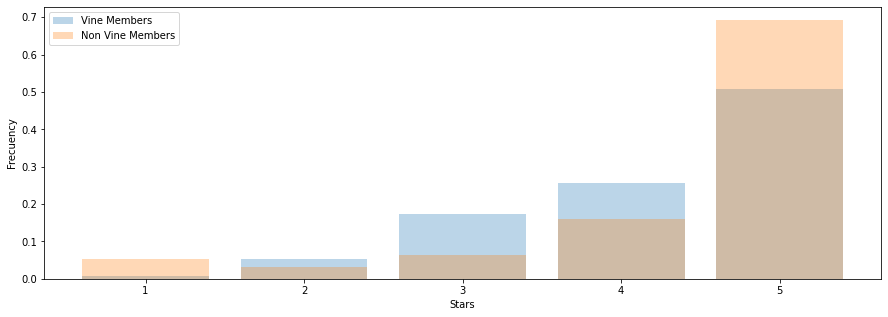

In [35]:
import matplotlib.pyplot as plt
hist_Y=hist_Y.sort_values("star_rating")
hist_N=hist_N.sort_values("star_rating")

total_s_y = hist_Y["Total Stars"].sum()
total_s_n = hist_N["Total Stars"].sum()

hist_Y["Percentage"] = hist_Y["Total Stars"]/total_s_y
hist_N["Percentage"] = hist_N["Total Stars"]/total_s_n

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(hist_Y["star_rating"],hist_Y["Percentage"], alpha=0.3)
ax.bar(hist_N["star_rating"],hist_N["Percentage"], alpha=0.3)
ax.set_xlabel("Stars")
ax.set_ylabel("Frecuency")

ax.legend(["Vine Members", "Non Vine Members"])

fig.show()